# Import dataset:

In [68]:
import os
print(os.getcwd())

C:\Users\Lenovo\OneDrive\Desktop\Data Analysis\Projects\Chocolate_data_analysis


In [69]:
# Example: set working directory to folder where file is saved
os.chdir(r"C:\Users\Lenovo\OneDrive\Desktop\Data Analysis\Projects\Chocolate_data_analysis")  

# Now read the CSV
import pandas as pd
df = pd.read_csv("Chocolate_Sales.csv")


# Data cleaning

In [70]:
df.dtypes

Sales Person     object
Country          object
Product          object
Date             object
Amount           object
Boxes Shipped     int64
dtype: object

In [71]:
df['Date'] = pd.to_datetime(df.Date)
df['Amount'] = df['Amount'].apply(lambda x: float(x.replace('$', '').replace(',', '').strip()))

In [72]:
#Count missing values in each column
df.isnull().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

In [73]:
df.duplicated().sum()

0

# Exploratory Data Analysis

In [74]:
df.describe()

,Amount,Boxes Shipped
count,1094.000000,1094.000000
mean,5652.308044,161.797989
std,4102.442014,121.544145
min,7.000000,1.000000
25%,2390.500000,70.000000
50%,4868.500000,135.000000
75%,8027.250000,228.750000
max,22050.000000,709.000000


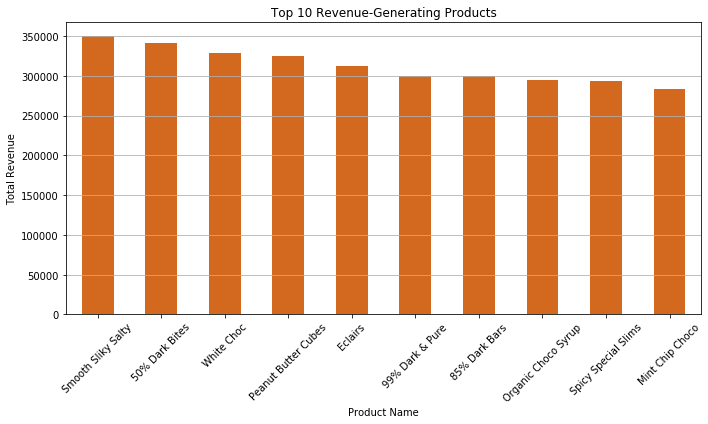

In [75]:
# Which Products Generate the Most Revenue?
top_products = df.groupby('Product')['Amount'].sum().sort_values(ascending=False).head(10)

top_products.plot(kind='bar', figsize=(10, 6), color='chocolate')
plt.title('Top 10 Revenue-Generating Products')
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


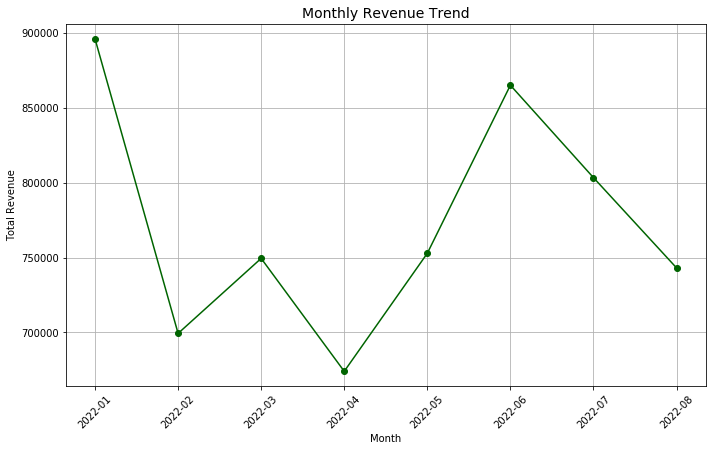

In [76]:
# Ensure 'Month' column is set
df['Month'] = df['Date'].dt.to_period('M')
monthly_revenue = df.groupby('Month')['Amount'].sum()

# Plot with enhancements
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue.index.astype(str), monthly_revenue.values, marker='o', color='darkgreen')

# Labels and layout
plt.title('Monthly Revenue Trend', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(True)

# Give padding to prevent cutting off top and bottom
plt.ylim(monthly_revenue.min() - 10000, monthly_revenue.max() + 10000)

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


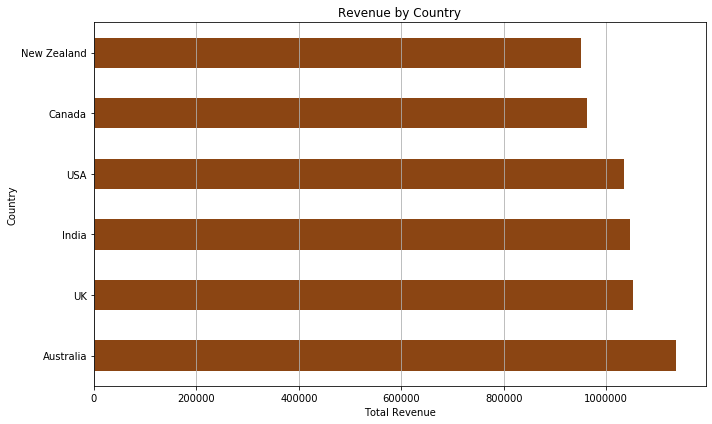

In [77]:
# Revenue by Country
country_revenue = df.groupby('Country')['Amount'].sum().sort_values(ascending=False)

country_revenue.plot(kind='barh', figsize=(10, 6), color='saddlebrown')
plt.title('Revenue by Country')
plt.xlabel('Total Revenue')
plt.ylabel('Country')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


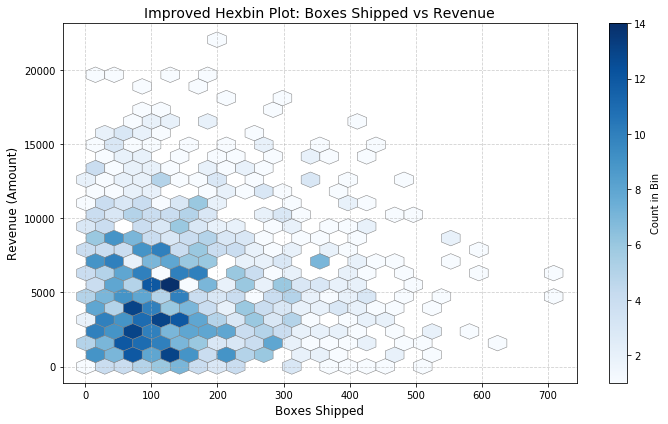

In [78]:
# Visualizing the relationship between boxes shipped and revenue using hexagonal binning
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

hb = plt.hexbin(
    df['Boxes Shipped'],
    df['Amount'],
    gridsize=25,               # slightly lower grid size = clearer groups
    cmap='Blues',              # clearer color contrast
    mincnt=1,
    edgecolors='grey',         # add hexagon borders
    linewidths=0.5
)

cb = plt.colorbar(hb)
cb.set_label('Count in Bin')

plt.title("Improved Hexbin Plot: Boxes Shipped vs Revenue", fontsize=14)
plt.xlabel("Boxes Shipped", fontsize=12)
plt.ylabel("Revenue (Amount)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Most shipments fall in the range of 0-200 boxes, generating revenue up to $5,000.

# The darkest concentration is in the lower left corner, showing that small shipments generating modest revenue 
# are the most common scenario.

# Sales forecasting

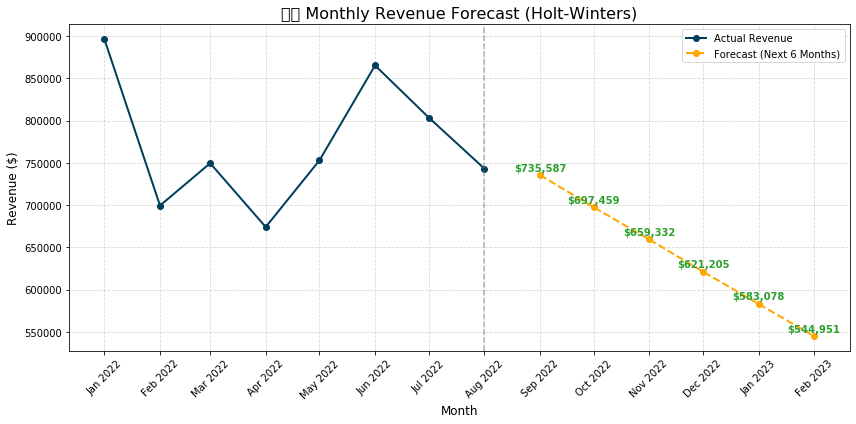

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Step 1: Prepare time series
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.to_period('M')
monthly_revenue = df.groupby('Month')['Amount'].sum()
monthly_revenue.index = monthly_revenue.index.to_timestamp()

# Step 2: Fit Holt-Winters model
model = ExponentialSmoothing(monthly_revenue, trend='add', seasonal=None)
fit = model.fit()

# Step 3: Forecast next 6 months
forecast = fit.forecast(6)
forecast_index = forecast.index

# Step 4: Combine for X-axis formatting
full_series = pd.concat([monthly_revenue, forecast])

# Step 5: Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue, label='Actual Revenue', marker='o', color='#003f5c', linewidth=2)
plt.plot(forecast, label='Forecast (Next 6 Months)', marker='o', linestyle='--', color='#ffa600', linewidth=2)

# Forecast point labels (clear + large)
for i in forecast_index:
    plt.text(
        i, forecast[i] + 5000,  # padding above point
        f"${forecast[i]:,.0f}",
        fontsize=10, fontweight='bold',
        color='#2ca02c',
        ha='center'
    )

# X-axis: one label per month
plt.xticks(full_series.index, [d.strftime('%b %Y') for d in full_series.index], rotation=45)

# Formatting
plt.axvline(monthly_revenue.index[-1], color='gray', linestyle='--', alpha=0.6)
plt.title('📈 Monthly Revenue Forecast (Holt-Winters)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# Customer Behavior Analysis 👥

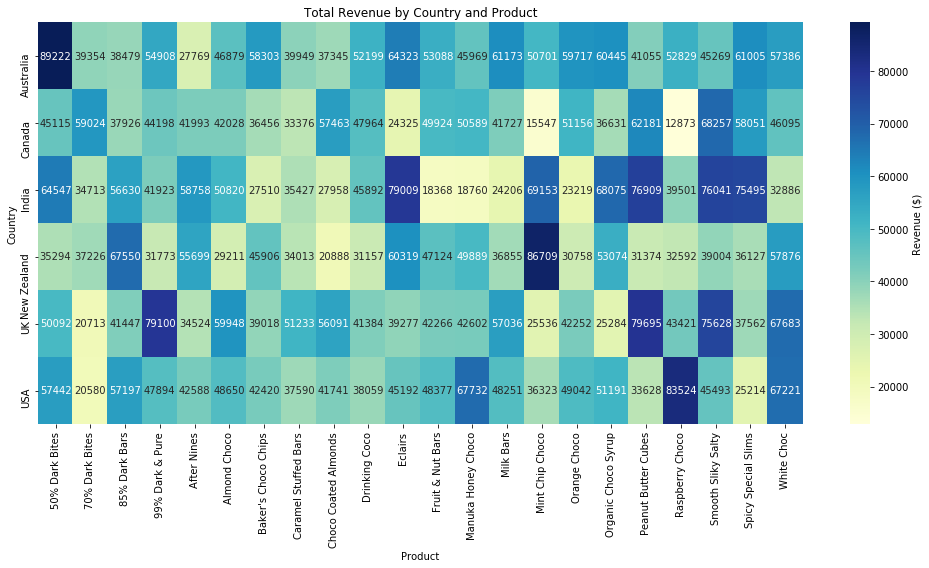

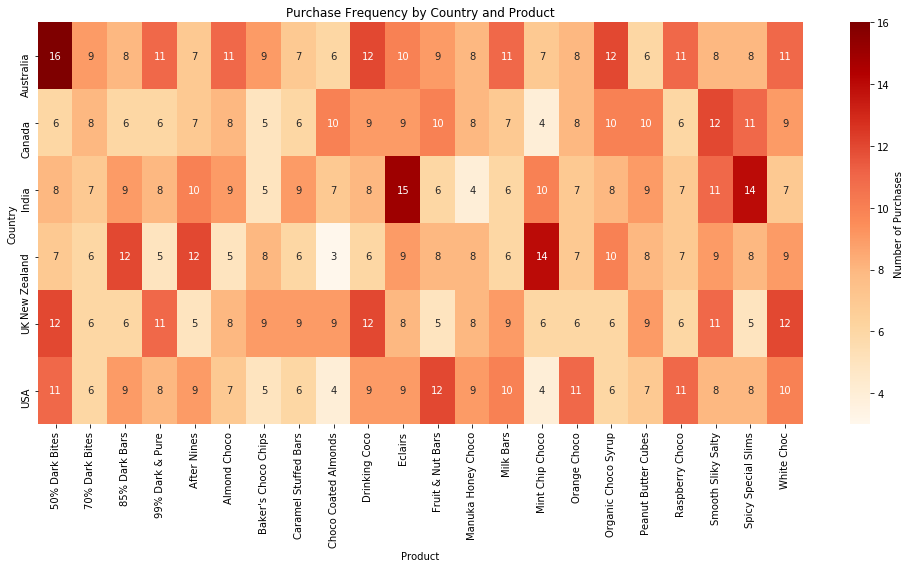

In [80]:
import seaborn as sns

# Assuming df is your cleaned DataFrame with columns: 'Country', 'Product', 'Amount', 'Date'

# 1. Total Revenue by Country and Product
revenue_pivot = df.pivot_table(index='Country', columns='Product', values='Amount', aggfunc='sum', fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(revenue_pivot, cmap='YlGnBu', annot=True, fmt=".0f", cbar_kws={'label': 'Revenue ($)'})
plt.title('Total Revenue by Country and Product')
plt.xlabel('Product')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

# 2. Purchase Frequency by Country and Product
frequency_pivot = df.pivot_table(index='Country', columns='Product', values='Amount', aggfunc='count', fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(frequency_pivot, cmap='OrRd', annot=True, fmt="d", cbar_kws={'label': 'Number of Purchases'})
plt.title('Purchase Frequency by Country and Product')
plt.xlabel('Product')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


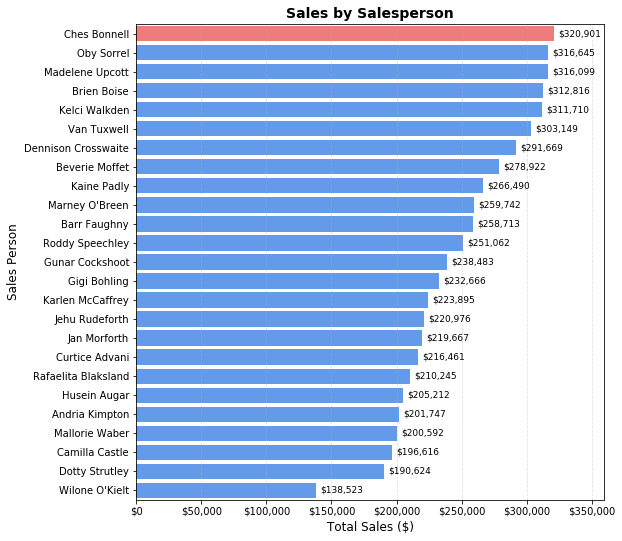

In [92]:
# Sales by Sales Person
from matplotlib.ticker import StrMethodFormatter

# Group and sort DESC
sales_by_person = (
    df.groupby('Sales Person', as_index=False)['Amount']
    .sum()
    .sort_values(by='Amount', ascending=False)
    .reset_index(drop=True)
)

# Identify top performer
top_seller = sales_by_person.iloc[0]['Sales Person']

# Custom color palette
colors = ['#FF6B6B' if person == top_seller else '#4D96FF' for person in sales_by_person['Sales Person']]

# Set figure
fig, ax = plt.subplots(figsize=(10, max(6, len(sales_by_person) * 0.35)))

# Barplot
sns.barplot(
    data=sales_by_person,
    y='Sales Person',
    x='Amount',
    palette=colors,
    ax=ax
)

# Add value labels with padding
for i, row in sales_by_person.iterrows():
    ax.text(
        row['Amount'] + 0.01 * sales_by_person['Amount'].max(),  # padding 1%
        i,
        f"${row['Amount']:,.0f}",
        va='center',
        fontsize=9
    )

# Set x-limit with margin to prevent cutoff
max_amount = sales_by_person['Amount'].max()
plt.xlim(0, max_amount * 1.12)  # Add 12% margin to the right

# Title and labels
ax.set_title("Sales by Salesperson", fontsize=14, weight='bold')
ax.set_xlabel("Total Sales ($)", fontsize=12)
ax.set_ylabel("Sales Person", fontsize=12)
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

# Grid and spacing
ax.grid(axis='x', linestyle='--', alpha=0.4)
plt.subplots_adjust(left=0.25)  # More space for long names

plt.show()
